In [733]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np

sns.set_palette("Dark2")
sns.plotting_context("talk")

produit = pd.read_csv("./data/products.csv")
client = pd.read_csv("./data/customers.csv")
vente = pd.read_csv("./data/transactions.csv")


# Vérification des tables

# Produit

In [692]:
print(produit.head(5))

  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.99      1
4  0_1507   3.99      0


In [693]:
print(produit.shape)
print(produit.describe(include='all'))

(3287, 3)
       id_prod        price        categ
count     3287  3287.000000  3287.000000
unique    3287          NaN          NaN
top     0_1421          NaN          NaN
freq         1          NaN          NaN
mean       NaN    21.856641     0.370246
std        NaN    29.847908     0.615387
min        NaN    -1.000000     0.000000
25%        NaN     6.990000     0.000000
50%        NaN    13.060000     0.000000
75%        NaN    22.990000     1.000000
max        NaN   300.000000     2.000000


'id_prod' est bel et bien une clé primaire, car ils sont tous uniques.

Cependant, on peut remarquer que certains prix sont négatifs

In [694]:
print(produit.sort_values(by='price'))

     id_prod   price  categ
731      T_0   -1.00      0
2355   0_202    0.62      0
2272   0_528    0.62      0
370    0_120    0.66      0
1211  0_1844    0.77      0
...      ...     ...    ...
2779    2_30  233.54      2
1436   2_167  236.99      2
394    2_158  247.22      2
724     2_76  254.44      2
947      2_2  300.00      2

[3287 rows x 3 columns]


On voit que le prix négatif correspond au produit 'T_0'

In [695]:
produit = produit[produit['id_prod'] != 'T_0']
print(produit.shape)
print(produit.describe(include='all'))

(3286, 3)
       id_prod        price        categ
count     3286  3286.000000  3286.000000
unique    3286          NaN          NaN
top     0_1421          NaN          NaN
freq         1          NaN          NaN
mean       NaN    21.863597     0.370359
std        NaN    29.849786     0.615446
min        NaN     0.620000     0.000000
25%        NaN     6.990000     0.000000
50%        NaN    13.075000     0.000000
75%        NaN    22.990000     1.000000
max        NaN   300.000000     2.000000


In [696]:
print("Les différentes valeurs de la colonne categ sont :",produit.categ.unique())

Les différentes valeurs de la colonne categ sont : [0 1 2]


# Client

In [697]:
print(client.head(5))

  client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943


In [698]:
print(client.shape)
print(client.describe(include='all'))

(8623, 3)
       client_id   sex        birth
count       8623  8623  8623.000000
unique      8623     2          NaN
top       c_4410     f          NaN
freq           1  4491          NaN
mean         NaN   NaN  1978.280877
std          NaN   NaN    16.919535
min          NaN   NaN  1929.000000
25%          NaN   NaN  1966.000000
50%          NaN   NaN  1979.000000
75%          NaN   NaN  1992.000000
max          NaN   NaN  2004.000000


De même pour 'client_id'

In [699]:
print("Les différentes valeurs de la colonne sex sont :",client.sex.unique())

Les différentes valeurs de la colonne sex sont : ['f' 'm']


# Vente

In [700]:
print(vente.head(5))

  id_prod                        date session_id client_id
0  0_1518  2022-05-20 13:21:29.043970   s_211425     c_103
1   1_251  2022-02-02 07:55:19.149409   s_158752    c_8534
2  0_1277  2022-06-18 15:44:33.155329   s_225667    c_6714
3   2_209  2021-06-24 04:19:29.835891    s_52962    c_6941
4  0_1509  2023-01-11 08:22:08.194479   s_325227    c_4232


On retire les lignes de test

In [701]:
vente = vente.drop(vente[vente.id_prod == 'T_0'].index)
vente['date'] = pd.to_datetime(vente['date'], format='%Y-%m-%d')

In [702]:
print(vente.shape)
print(vente.describe(include='all',datetime_is_numeric=True))

(679332, 4)
       id_prod                           date session_id client_id
count   679332                         679332     679332    679332
unique    3266                            NaN     342315      8600
top      1_369                            NaN   s_118668    c_1609
freq      2252                            NaN         14     25488
mean       NaN  2022-03-03 15:13:19.307389696        NaN       NaN
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN
25%        NaN  2021-09-08 09:14:25.055994368        NaN       NaN
50%        NaN  2022-03-03 07:50:20.817730560        NaN       NaN
75%        NaN  2022-08-30 23:57:08.555173888        NaN       NaN
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN


# Fusion des Tables

In [703]:
tableTotale = pd.merge(vente, produit, on='id_prod', how='left')
tableTotale = pd.merge(tableTotale, client, on='client_id', how='left')

print(f' vente shape is :{vente.shape}')
print(f' produit shape is :{produit.shape}')
print(f' client shape is :{client.shape}')
print(f' tableTotale shape is :{tableTotale.shape}')

 vente shape is :(679332, 4)
 produit shape is :(3286, 3)
 client shape is :(8623, 3)
 tableTotale shape is :(679332, 8)


In [704]:
print(tableTotale.shape)
print(tableTotale.describe(include='all', datetime_is_numeric=True))

(679332, 8)
       id_prod                           date session_id client_id  \
count   679332                         679332     679332    679332   
unique    3266                            NaN     342315      8600   
top      1_369                            NaN   s_118668    c_1609   
freq      2252                            NaN         14     25488   
mean       NaN  2022-03-03 15:13:19.307389696        NaN       NaN   
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN   
25%        NaN  2021-09-08 09:14:25.055994368        NaN       NaN   
50%        NaN  2022-03-03 07:50:20.817730560        NaN       NaN   
75%        NaN  2022-08-30 23:57:08.555173888        NaN       NaN   
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN   
std        NaN                            NaN        NaN       NaN   

                price          categ     sex          birth  
count   679111.000000  679111.000000  679332  679332.000000  
unique            NaN  

On remarque qu'il y a des prix et des catégories qui ne sont pas renseignées

In [705]:
print(tableTotale[tableTotale['price'].isna()]['id_prod'].unique())

['0_2245']


In [706]:
print(produit[produit['id_prod'] == '0_2245'].shape)

(0, 3)


In [707]:
print(vente[vente['id_prod'] == '0_2245'].shape)

(221, 4)


Ce produit n'apparait pas dans la table produit ce qui explique qui ne possède ni prix ni catégorie, pourtant il a été vendu 221 fois. Sur les 658664 ventes ce nombre est négligeable. D'autant plus si on remarque que le premier nombre de l'id produit correspond à la catégorie et que la catégorie 0 est la catégorie avec les prix les moins chères en moyenne.

In [708]:
tableTotale = tableTotale[tableTotale['id_prod'] != '0_2245']

# Calcul du chiffre d'affaire

<AxesSubplot:xlabel='date', ylabel='semestre'>

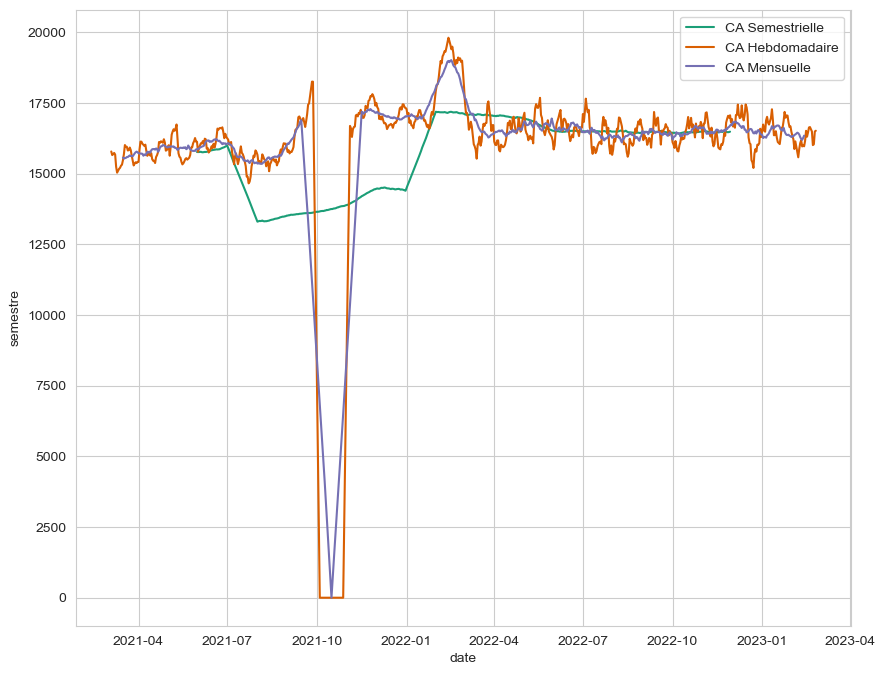

In [734]:
chiffreAffaire = tableTotale[['price', 'date', 'id_prod', 'categ']].sort_values(by='date')
plt.figure(figsize=(10, 8))

chiffreAffaireJournalier = tableTotale[['price', 'date']].resample('D', on='date').sum()

chiffreAffaireJournalier['jour'] = chiffreAffaireJournalier['price'].rolling(1).mean().shift(0)
chiffreAffaireJournalier['semaine'] = chiffreAffaireJournalier['price'].rolling(7).mean().shift(-3)
chiffreAffaireJournalier['mois'] = chiffreAffaireJournalier['price'].rolling(31).mean().shift(-15)
chiffreAffaireJournalier['semestre'] = chiffreAffaireJournalier['price'].rolling(183).mean().shift(-91)

"""
sns.lineplot(x="date",y="price",
             label="CA Journalier", data=chiffreAffaireJournalier,
             ci=None)
"""
# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semestre",
             label="CA Semestrielle",
             data=chiffreAffaireJournalier,
             ci=None)

# 7-day rolling average Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semaine",
             label="CA Hebdomadaire",
             data=chiffreAffaireJournalier,
             ci=None)

# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="mois",
             label="CA Mensuelle",
             data=chiffreAffaireJournalier,
             ci=None)

# Nombre de Ventes par catégorie

<AxesSubplot:xlabel='date', ylabel='Count'>

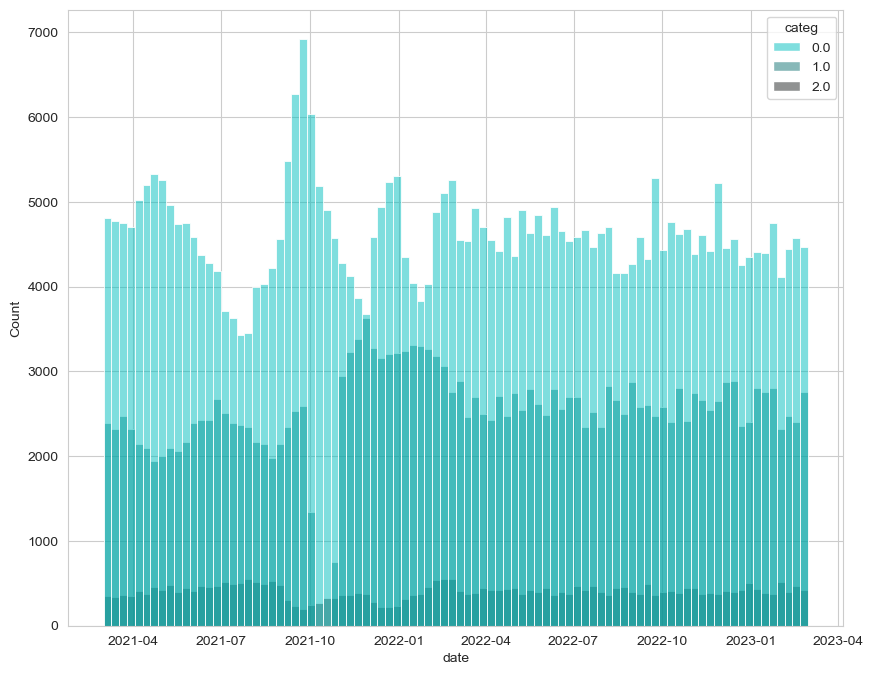

In [710]:
plt.figure(figsize=(10,8))
sns.histplot(data=tableTotale, x='date', hue='categ',palette="dark:c_r")



Comme on peut le voir, il manque certaines données sur le mois d'octobre. On va donc complétement effacer les données du mois d'octobre 2021.

In [711]:
tailleAv = len(tableTotale.index)
tableTotale = tableTotale.loc[tableTotale['date'].dt.strftime('%Y%m') != pd.Timestamp(year=2021, month=10,day=1).strftime('%Y%m')]
tailleAp = len(tableTotale.index)

print("on a supprimé",tailleAv-tailleAp,"lignes, soit",round(((tailleAv-tailleAp)/tailleAv)*100,2),"% du dataframe original.")

on a supprimé 21599 lignes, soit 3.18 % du dataframe original.


# Calcul du nouveau chiffre d'affaires

<AxesSubplot:xlabel='date', ylabel='semestre'>

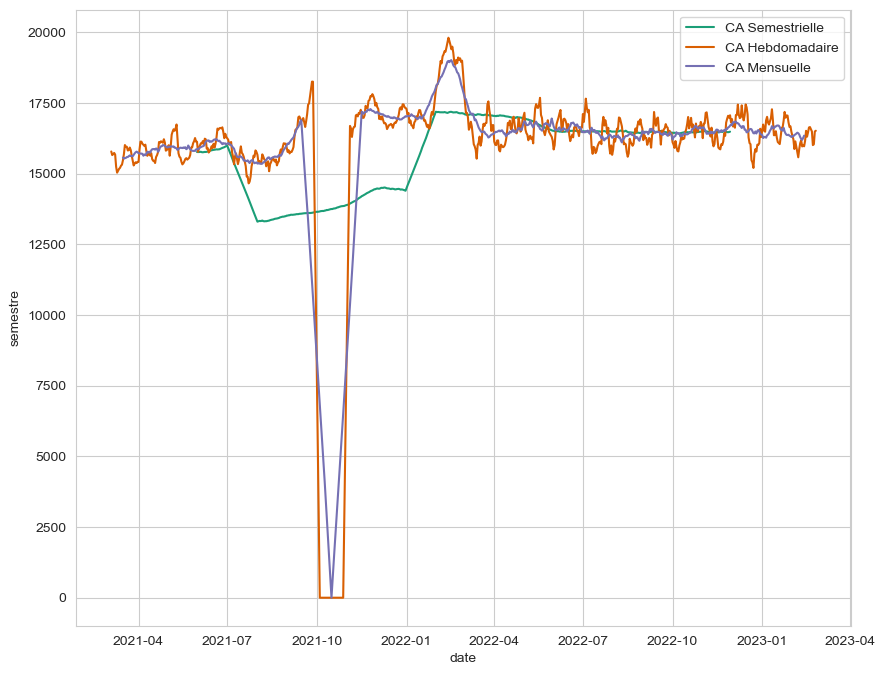

In [735]:
chiffreAffaire = tableTotale[['price', 'date', 'id_prod', 'categ']].sort_values(by='date')
plt.figure(figsize=(10, 8))

chiffreAffaireJournalier = tableTotale[['price', 'date']].resample('D', on='date').sum()

chiffreAffaireJournalier['jour'] = chiffreAffaireJournalier['price'].rolling(1).mean().shift(0)
chiffreAffaireJournalier['semaine'] = chiffreAffaireJournalier['price'].rolling(7).mean().shift(-3)
chiffreAffaireJournalier['mois'] = chiffreAffaireJournalier['price'].rolling(31).mean().shift(-15)
chiffreAffaireJournalier['semestre'] = chiffreAffaireJournalier['price'].rolling(183).mean().shift(-91)

"""
sns.lineplot(x="date",y="price",
             label="CA Journalier", data=chiffreAffaireJournalier,
             ci=None)
"""
# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semestre",
             label="CA Semestrielle",
             data=chiffreAffaireJournalier,
             ci=None)

# 7-day rolling average Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="semaine",
             label="CA Hebdomadaire",
             data=chiffreAffaireJournalier,
             ci=None)

# Time series plot with Seaborn lineplot() with label
sns.lineplot(x="date", y="mois",
             label="CA Mensuelle",
             data=chiffreAffaireJournalier,
             ci=None)

# Nouvelles ventes par catégorie

<AxesSubplot:xlabel='date', ylabel='Count'>

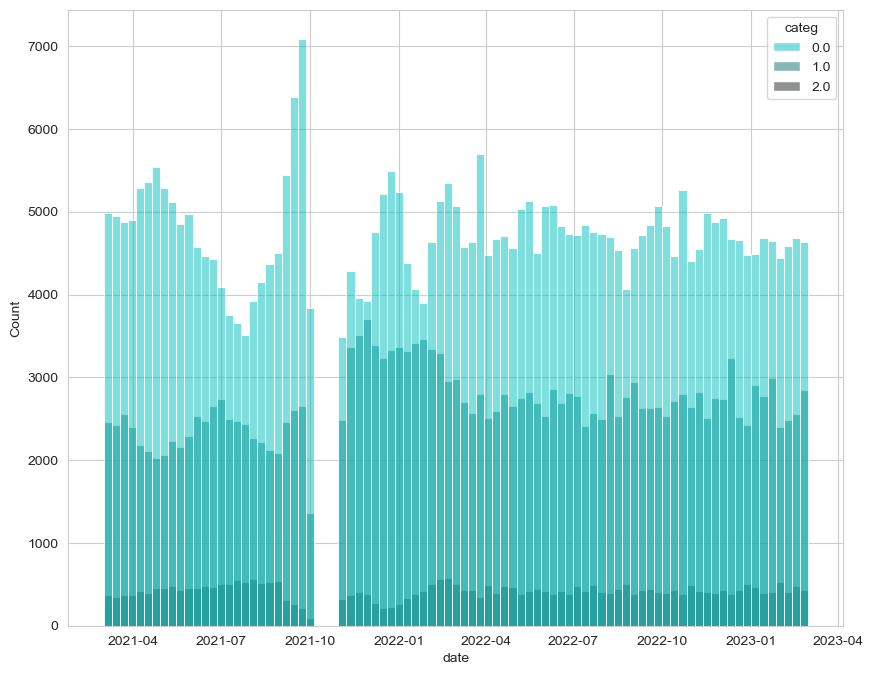

In [713]:
plt.figure(figsize=(10,8))
sns.histplot(data=tableTotale, x='date', hue='categ',palette="dark:c_r")

# Ajout de nouvelles colonnes

Création d'une tranche d'age

In [714]:
def arrondiDizaineInf(n):
    while n%10 !=0:
        n=n-1
    return n

In [715]:
tableTotale['age'] = pd.DatetimeIndex(tableTotale['date']).year - tableTotale['birth']

In [716]:
tableTotale['trancheAge'] = tableTotale['age'].apply(arrondiDizaineInf).apply(str)\
                            +'-'\
                            +(tableTotale['age'].apply(arrondiDizaineInf)+10).apply(str)


In [717]:
print(tableTotale.sample(5))

       id_prod                       date session_id client_id  price  categ  \
31350   0_1291 2021-06-05 00:13:28.217394    s_44167    c_5402  16.99    0.0   
376441  0_1157 2021-09-13 20:11:20.637421    s_89433    c_2783  18.99    0.0   
268234  0_1816 2022-01-03 05:23:36.065230   s_144201    c_1605   7.33    0.0   
391449   1_412 2022-09-08 19:23:08.653063   s_265217    c_7801  16.65    1.0   
568653  0_1434 2021-11-20 14:38:59.925128   s_122485    c_6327   8.58    0.0   

       sex  birth  age trancheAge  
31350    m   1973   48      40-50  
376441   m   1986   35      30-40  
268234   m   1995   27      20-30  
391449   f   1945   77      70-80  
568653   f   1954   67      60-70  


In [718]:
print(tableTotale.shape)
print(tableTotale.describe(include='all', datetime_is_numeric=True))

(657512, 10)
       id_prod                           date session_id client_id  \
count   657512                         657512     657512    657512   
unique    3263                            NaN     330731      8598   
top      1_369                            NaN   s_118668    c_1609   
freq      2237                            NaN         14     24472   
mean       NaN  2022-03-08 03:59:26.060106240        NaN       NaN   
min        NaN     2021-03-01 00:01:07.843138        NaN       NaN   
25%        NaN  2021-09-02 21:01:11.439571456        NaN       NaN   
50%        NaN     2022-03-14 23:06:31.924672        NaN       NaN   
75%        NaN  2022-09-05 21:29:50.094605568        NaN       NaN   
max        NaN     2023-02-28 23:58:30.792755        NaN       NaN   
std        NaN                            NaN        NaN       NaN   

                price          categ     sex          birth            age  \
count   657512.000000  657512.000000  657512  657512.000000  657512.

Ajout de la fréquence d'achat (nombre d'achats moyen par mois)

In [719]:
max,min = tableTotale['date'].max(),tableTotale['date'].min()

nbMois = (max - min)/np.timedelta64(1, 'M')
nbMois = round(nbMois)

print("Les données s'étalent sur", nbMois,"mois,",nbMois-1, "si on ne prend pas en compte le mois d'octobre")

Les données s'étalent sur 24 mois, 23 si on ne prend pas en compte le mois d'octobre


On ajoute la fréquence d'achat en ignorant le mois d'octobre

In [720]:
tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id').count()['date'].reset_index().rename(columns={'date': 'nombre d\'achats'}),
    how='left', on='client_id')

tableTotale = tableTotale.merge(
    tableTotale.groupby('client_id')['date'].agg(['min']).reset_index().rename(columns={'min': 'date_inscription'}),
    how='left', on='client_id')

tableTotale['date_inscription'] = np.where(tableTotale['date_inscription']<'2021-10-01',
                                           tableTotale['date_inscription'] +  pd.DateOffset(months=1),
                                           tableTotale['date_inscription'])


tableTotale['ventes_mensuelles'] = round(tableTotale['nombre d\'achats'] / (((tableTotale['date'].max() - tableTotale['date_inscription'])/np.timedelta64(1, 'M'))),2)

print(tableTotale.describe(datetime_is_numeric=True))
print(tableTotale.sort_values(by='price'))

                                date          price          categ  \
count                         657512  657512.000000  657512.000000   
mean   2022-03-08 03:59:26.060106240      17.540258       0.450375   
min       2021-03-01 00:01:07.843138       0.620000       0.000000   
25%    2021-09-02 21:01:11.439571456       8.990000       0.000000   
50%       2022-03-14 23:06:31.924672      13.990000       0.000000   
75%    2022-09-05 21:29:50.094605568      19.080000       1.000000   
max       2023-02-28 23:58:30.792755     300.000000       2.000000   
std                              NaN      18.340492       0.595776   

               birth            age  nombre d'achats  \
count  657512.000000  657512.000000    657512.000000   
mean     1977.776570      43.915959      1260.097467   
min      1929.000000      17.000000         1.000000   
25%      1970.000000      35.000000        63.000000   
50%      1980.000000      42.000000       119.000000   
75%      1987.000000      51.0000

(Importance des plus grosses fréquences d'achats)

<AxesSubplot:xlabel='ventes_mensuelles', ylabel='Count'>

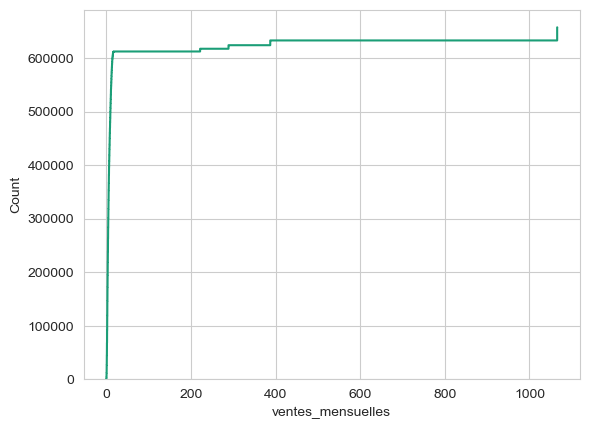

In [736]:
# sns.displot(tableTotale.sort_values(by='ventes_mensuelles'), x="ventes_mensuelles", kind="ecdf")
sns.histplot(
    data=tableTotale, x="ventes_mensuelles",
    element="step", fill=False,
    cumulative=True, common_norm=False,
)

<AxesSubplot:>

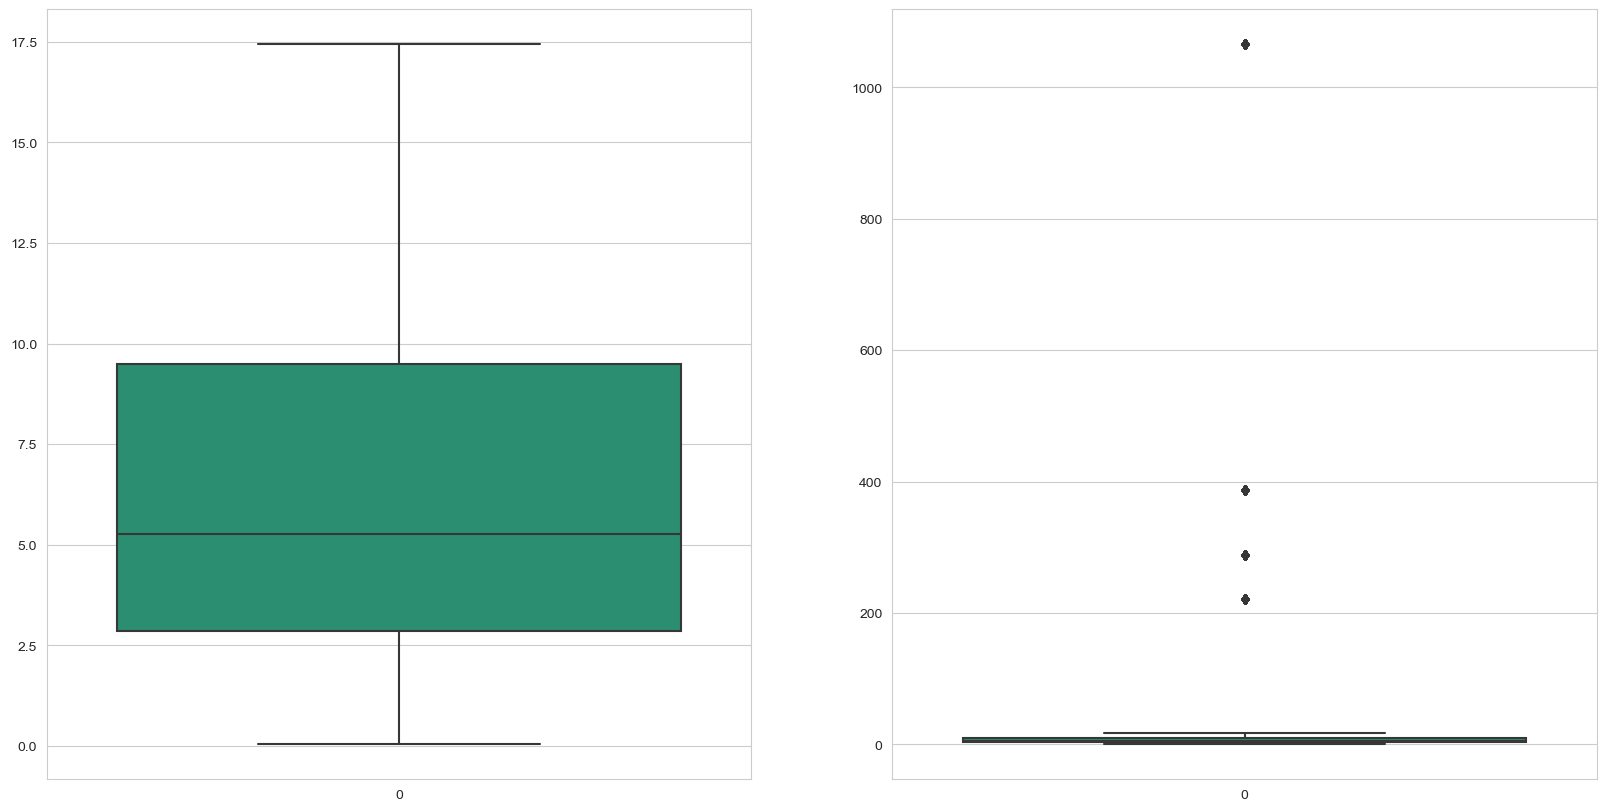

In [737]:
f, (ax_box1, ax_box) = plt.subplots(nrows=1, ncols=2, sharex=False,  figsize=(20,10))
sns.boxplot(data=tableTotale['ventes_mensuelles'], showfliers=False, ax=ax_box1)
sns.boxplot(data=tableTotale['ventes_mensuelles'], showfliers=True, ax=ax_box)

On remarque que 4 clients ont une fréquence d'achat anormalement élevée

In [723]:
clientAnormal = tableTotale[tableTotale['ventes_mensuelles']>17.5]['client_id'].unique()
print(clientAnormal)

['c_6714' 'c_4958' 'c_1609' 'c_3454']


Afin d'obtenir une étude plus cohérente, on décide de séparer ces clients des autres

In [724]:
tableTotaleNormal = tableTotale[~tableTotale['client_id'].isin(clientAnormal)]
tableTotaleAnormal = tableTotale[tableTotale['client_id'].isin(clientAnormal)]

tableTotale['anormal'] = 'Client \'Normal\''
tableTotale.loc[tableTotale['client_id'].isin(clientAnormal),'anormal'] = 'Client \'Anormal\''

# Chiffre d'affaires par produit

     id_prod           anormal  Chiffre d'affaires   categ    birth    age  \
0        0_0  Client 'Anormal'              348.75     0.0   183802   4216   
1        0_0   Client 'Normal'             4128.75     0.0  2177710  48160   
2        0_1  Client 'Anormal'              219.80     0.0    39530    901   
3        0_1   Client 'Normal'             4934.51     0.0   888416  19319   
4       0_10  Client 'Anormal'               35.90     0.0     3960     83   
...      ...               ...                 ...     ...      ...    ...   
5553    2_96   Client 'Normal'            25679.76  1072.0  1069593  14052   
5554    2_97  Client 'Anormal'              321.98     4.0     3998     45   
5555    2_97   Client 'Normal'             1770.89    22.0    21964    276   
5556    2_98   Client 'Normal'              149.74     2.0     2003     18   
5557    2_99   Client 'Normal'              594.93    14.0    13980    173   

      nombre d'achats  ventes_mensuelles    SumAll  
0         

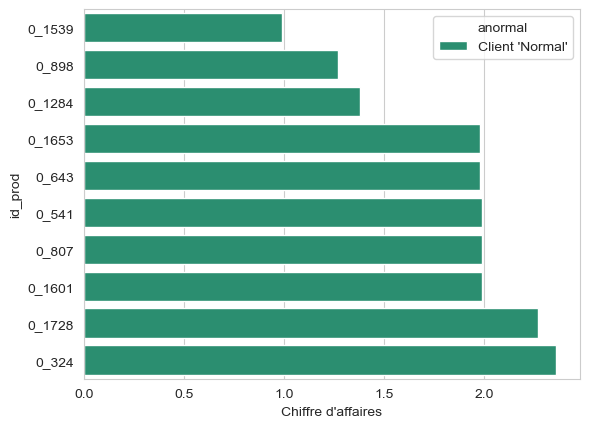

<AxesSubplot:xlabel="Chiffre d'affaires", ylabel='id_prod'>

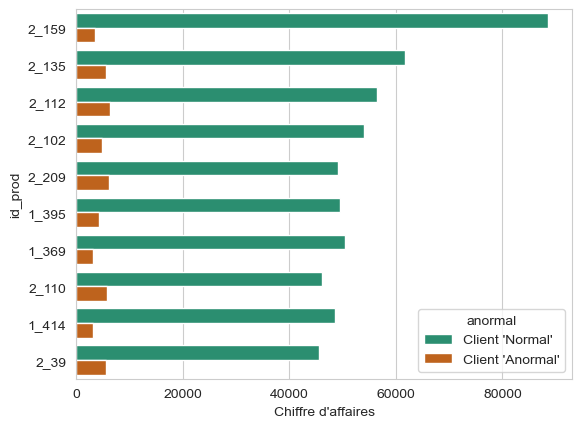

In [738]:

chiffreAffaireProduit = tableTotale.copy(deep=True)
chiffreAffaireProduit.set_index('date')
chiffreAffaireProduit.index = pd.to_datetime(chiffreAffaireProduit.index)
chiffreAffaireProduit = chiffreAffaireProduit.groupby(['id_prod','anormal']).sum().reset_index().sort_values(by='price').rename(columns={"price": "Chiffre d'affaires"})

chiffreAffaireProduit['SumAll'] = chiffreAffaireProduit["Chiffre d'affaires"].groupby(chiffreAffaireProduit['id_prod']).transform('sum')
print(chiffreAffaireProduit.sort_values(by='id_prod'))

chiffreAffaireProduit = chiffreAffaireProduit.sort_values(by='SumAll')
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduit.head(10), hue='anormal')
plt.show()

chiffreAffaireProduit = chiffreAffaireProduit.sort_values(by='SumAll',ascending=False)
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduit.head(20), hue='anormal')


     id_prod           anormal  Chiffre d'affaires   categ    birth     age  \
3090   0_528  Client 'Anormal'                0.62     0.0     1980      41   
372   0_1191   Client 'Normal'                0.99     0.0     1978      43   
1824  0_1935  Client 'Anormal'                0.99     0.0     1980      41   
1068  0_1539   Client 'Normal'                0.99     0.0     1988      33   
3701   0_898   Client 'Normal'                1.27     0.0     1972      49   
...      ...               ...                 ...     ...      ...     ...   
4370   1_369   Client 'Normal'            50546.93  2107.0  4158050  101718   
5158   2_102   Client 'Normal'            54113.10  1830.0  1826404   23488   
5178   2_112   Client 'Normal'            56420.95  1670.0  1667349   20801   
5218   2_135   Client 'Normal'            61746.05  1790.0  1785797   23621   
5269   2_159   Client 'Normal'            88615.93  1214.0  1203109   24055   

      nombre d'achats  ventes_mensuelles  
3090    

[Text(0.5, 0, "Chiffre d'affaires")]

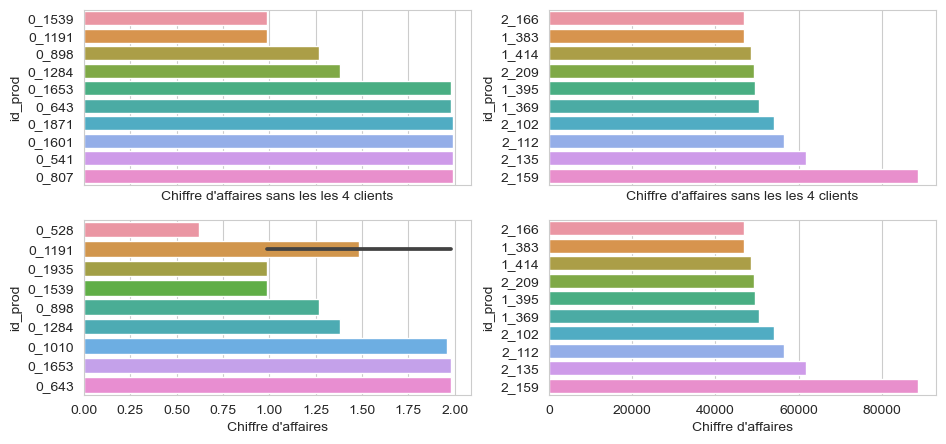

In [739]:
fig5, axs = plt.subplots(2, 2,sharex="col", figsize=(11,5),
                         gridspec_kw=dict(height_ratios=[1, 1],
                                          width_ratios=[1, 1]))


axgN,axdN,axgA,axdA = axs[0,0], axs[0,1], axs[1,0], axs[1,1]

chiffreAffaireProduit = tableTotale.copy(deep=True)
chiffreAffaireProduit.set_index('date')
chiffreAffaireProduit.index = pd.to_datetime(chiffreAffaireProduit.index)
chiffreAffaireProduit = chiffreAffaireProduit.groupby(['id_prod','anormal']).sum().reset_index().sort_values(by='price').rename(columns={"price": "Chiffre d'affaires"})

print(chiffreAffaireProduit)

chiffreAffaireProduitNormal = tableTotaleNormal.copy(deep=True)
chiffreAffaireProduitNormal.set_index('date')
chiffreAffaireProduitNormal.index = pd.to_datetime(chiffreAffaireProduitNormal.index)
chiffreAffaireProduitNormal = chiffreAffaireProduitNormal.groupby('id_prod').sum().reset_index().sort_values(by='price').rename(columns={"price": "Chiffre d'affaires"})


sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduit.head(10), label="Total", ax=axgA)
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduitNormal.head(10), label="Total",ax=axgN)
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduit.tail(10), label="Total",ax=axdA)
sns.barplot(x="Chiffre d'affaires", y="id_prod", data=chiffreAffaireProduitNormal.tail(10), label="Total",ax=axdN)

"""
chiffreAffaireProduit.head(15)[['Chiffre d\'affaires']].plot.barh()
chiffreAffaireProduit.tail(15)[['Chiffre d\'affaires']].plot.barh()
"""

axgN.set(xlabel='Chiffre d\'affaires sans les les 4 clients')
axgA.set(xlabel='Chiffre d\'affaires')
axdN.set(xlabel='Chiffre d\'affaires sans les les 4 clients')
axdA.set(xlabel='Chiffre d\'affaires')


# Chiffre d'affaire par catégorie

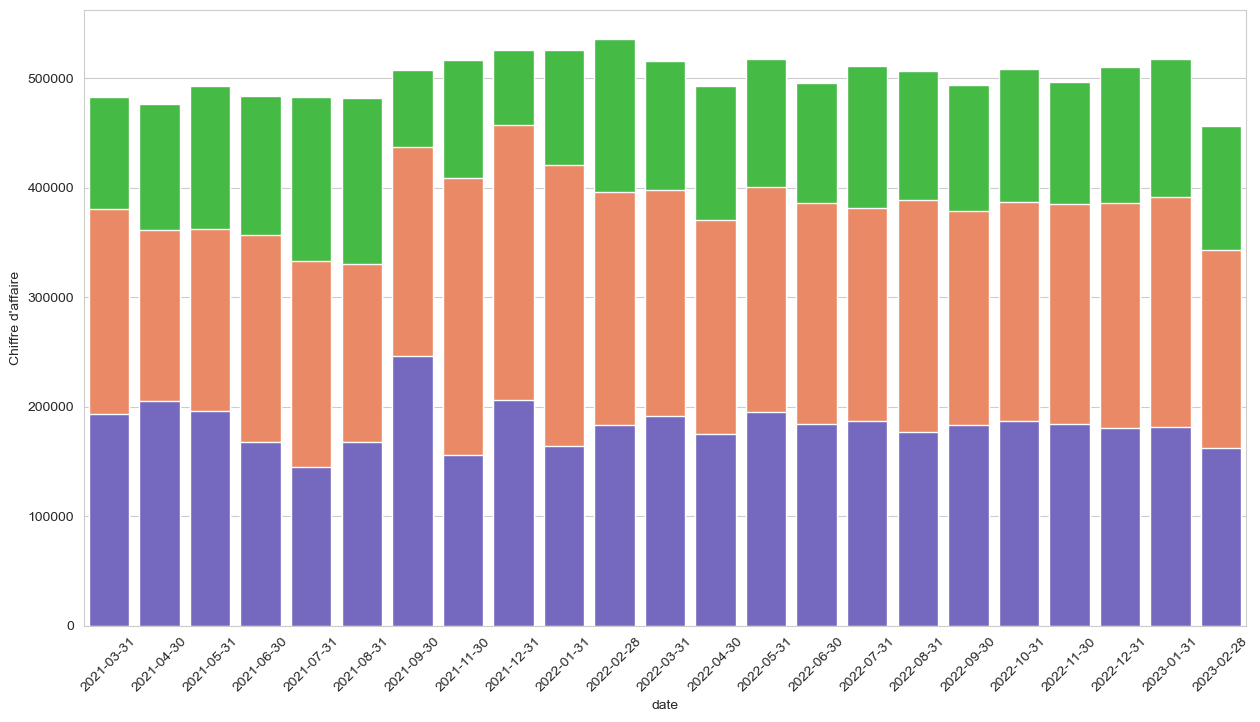

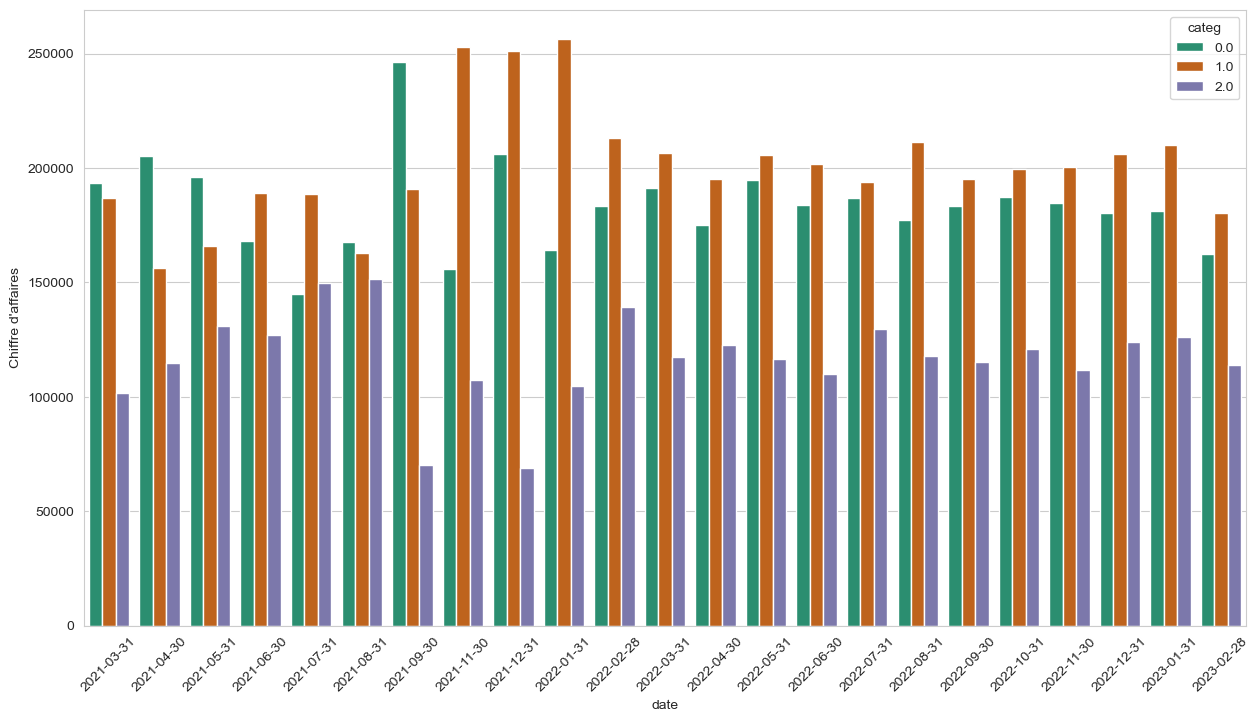

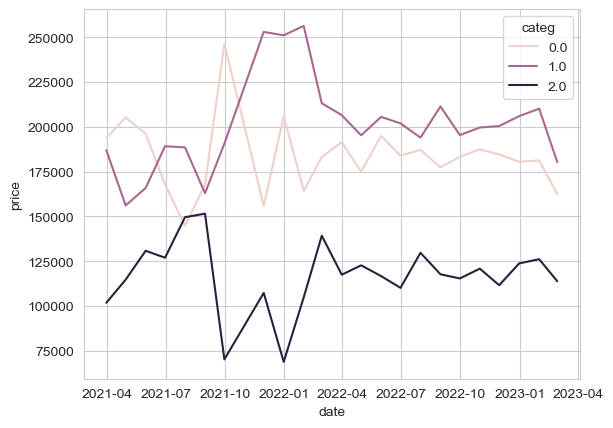

          date  categ      price
0   2021-03-31    0.0  193629.17
1   2021-03-31    1.0  186974.17
2   2021-03-31    2.0  101837.27
3   2021-04-30    0.0  205222.46
4   2021-04-30    1.0  156138.35
..         ...    ...        ...
64  2023-01-31    1.0  210104.41
65  2023-01-31    2.0  126153.08
66  2023-02-28    0.0  162457.00
67  2023-02-28    1.0  180347.24
68  2023-02-28    2.0  113875.52

[69 rows x 3 columns]


In [740]:
plt.figure(figsize=(15,8))
chiffreAffaireCategorie = tableTotale.groupby(by=[pd.Grouper(key='date', freq='M'), 'categ'])['price'].sum().unstack(fill_value=0).reset_index()
chiffreAffaireCategorie['date'] = pd.to_datetime(chiffreAffaireCategorie['date']).dt.date
chiffreAffaireCategorie[1.0] = chiffreAffaireCategorie[1.0] + chiffreAffaireCategorie[0.0]
chiffreAffaireCategorie[2.0] = chiffreAffaireCategorie[1.0] + chiffreAffaireCategorie[2.0]

sns.barplot(x = 'date', y = 2.0, data = chiffreAffaireCategorie, color = 'limegreen')
sns.barplot(x = 'date', y = 1.0, data = chiffreAffaireCategorie, color = 'coral')
sns.barplot(x = 'date', y = 0.0, data = chiffreAffaireCategorie, color = 'slateblue')

plt.ylabel('Chiffre d\'affaire')
plt.xticks(rotation=45)


chiffreAffaireCategorie = chiffreAffaire.copy(deep=True)

plt.figure(figsize=(15,8))
chiffreAffaireCategorie = chiffreAffaireCategorie.groupby(by=[pd.Grouper(key='date', freq='M'), 'categ'])['price'].sum().reset_index()#.unstack(fill_value=0)##
chiffreAffaireCategorie['date'] = pd.to_datetime(chiffreAffaireCategorie['date']).dt.date

sns.barplot(data=chiffreAffaireCategorie,x='date',y='price',hue='categ')
plt.xticks(rotation=45)
plt.ylabel('Chiffre d\'affaires')
plt.show()

sns.lineplot(data=chiffreAffaireCategorie,x='date',y='price',hue='categ')
#chiffreAffaireCategorie.plot.bar(stacked=True, x='date')
plt.show()
print(chiffreAffaireCategorie)



<AxesSubplot:xlabel='date', ylabel="Chiffre d'affaires total">

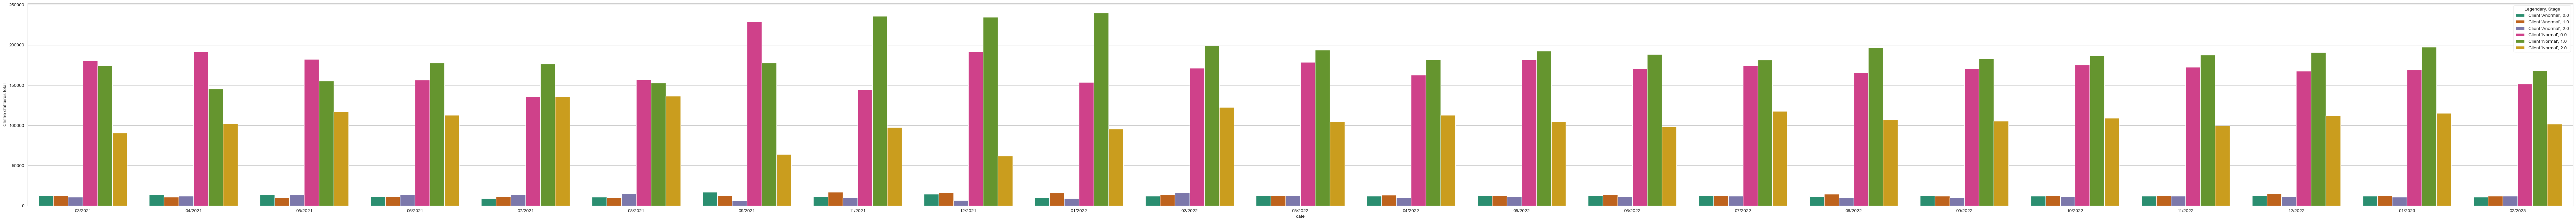

In [741]:
plt.figure(figsize=(100,8))



chiffreAffaireCategorie = tableTotale.groupby(by=[pd.Grouper(key='date', freq='M'), 'categ', 'anormal'])['price'].sum().unstack(fill_value=0).reset_index()

chiffreAffaireCategorie['date'] = pd.to_datetime(chiffreAffaireCategorie['date']).dt.strftime('%m/%Y')

chiffreAffaireCategorie = pd.melt(chiffreAffaireCategorie, id_vars=["date",'categ'], var_name="Type_client", value_name="Chiffre d\'affaires total")


hue = chiffreAffaireCategorie[['Type_client', 'categ']].apply(
    lambda row: f"{row.Type_client}, {row.categ}", axis=1)
hue.name = 'Legendary, Stage'
sns.barplot(x='date', y="Chiffre d\'affaires total", hue=hue, data=chiffreAffaireCategorie)



# Répartition des clients

# Courbe de Lorenz

In [730]:
def lorenz(variable, title, ax):
    X = variable.values
    X = np.sort(X)

    # Indice de Gini
    def gini(array):
        sorted_array = array.copy()
        sorted_array.sort()
        n = array.size
        coef_ = 2. / n
        const_ = (n + 1.) / n
        weighted_sum = sum([(i + 1) * yi for i, yi in enumerate(sorted_array)])
        return coef_ * weighted_sum / (sorted_array.sum()) - const_

    print('Incide de Gini :', gini(X))

    # Courbe de Lorenz
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0)
    # X_lorenz[0], X_lorenz[-1]
    y = np.arange(X_lorenz.size) / (X_lorenz.size - 1)
    lorenz = pd.DataFrame()
    lorenz['X'] = pd.Series(X_lorenz)
    lorenz['Y'] = pd.Series(y)
    sns.scatterplot(data=lorenz, x='Y', y='X', marker='x', ax=ax)

    # Diagonale
    a = np.arange(0, 1, .01)
    x = a
    y = a

    # Graphique
    sns.lineplot(x=x, y=y, ax=ax)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set(xlabel=title)


Incide de Gini : 0.44739817096802437
Incide de Gini : 0.40372319291525693


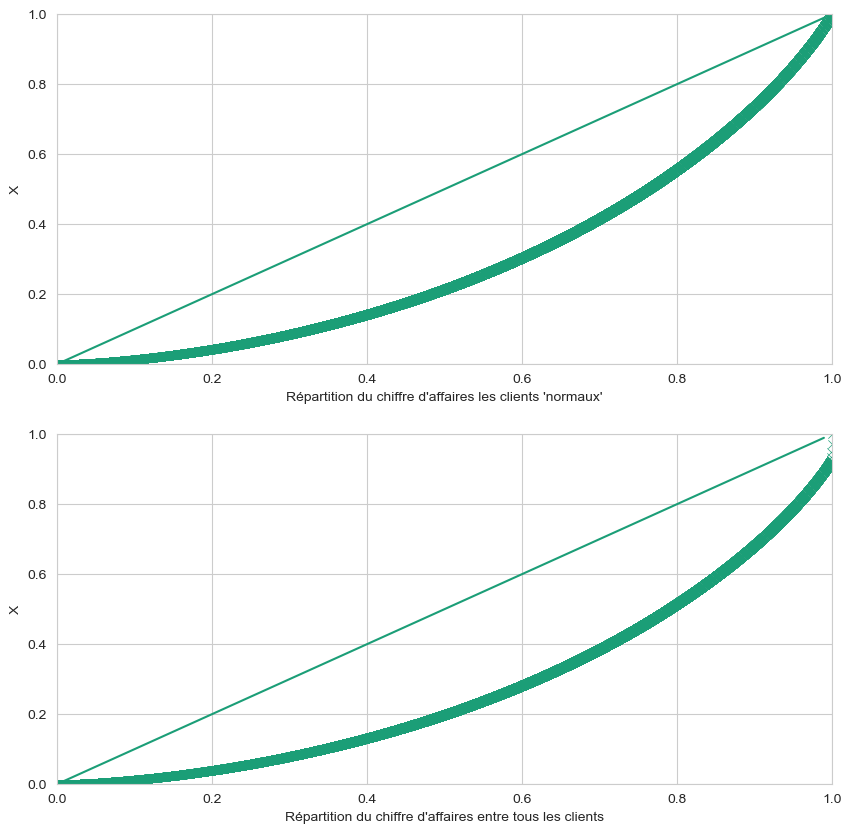

In [742]:
chiffreAffaireClient = tableTotale.groupby('client_id')['price'].sum().rename('chiffre d\'affaire').sort_values()
chiffreAffaireClientNormaux = tableTotaleNormal.groupby('client_id')['price'].sum().rename('chiffre d\'affaire').sort_values()

fig, (ax1,ax2) = plt.subplots(2, figsize=(10,10))


lorenz(chiffreAffaireClient, 'Répartition du chiffre d\'affaires entre tous les clients', ax2)
lorenz(chiffreAffaireClientNormaux, 'Répartition du chiffre d\'affaires les clients \'normaux\'', ax1)

# Corrélation entre les caractéristiques

<AxesSubplot:>

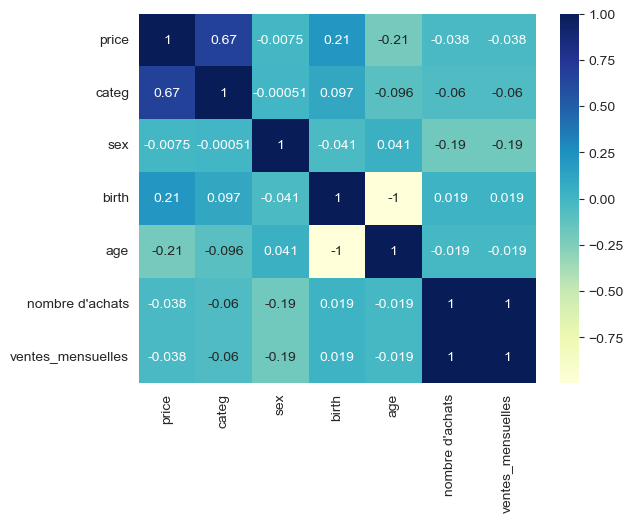

In [732]:
#Lien entre données
sns.heatmap(tableTotale.replace({"m": 0,"f": 1}).corr(), annot = True, fmt='.2g',cmap= 'YlGnBu')